## Importing Libraries

In [107]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import hstack
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Final touchups to the dataframe

Reading dataframe processed by `preprocessing.ipynb` and `add_scraped_data.ipynb`

In [108]:
df = pd.read_pickle('../Data/working_dataset_v2.pkl')
print(f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB")

1.5236726389121131 GB


Parent cos angle is `None` for the roots, should be imputed to 1

In [109]:
df.loc[df.is_root, 'parent_cos_angle'] = 1

Word count needs to be capped, let's see what the 99.5 percentile is:

In [110]:
df.word_counts.max(), df.word_counts.quantile(0.995)

(2114, 285.0)

Hence, let's remove the comments that have word counts more than 280, as these are probably outliers:

In [111]:
df = df[df['word_counts'] < 280]

Observations with `removed` or `deleted` in body are not useful. Neither are the ones with emoty body:

In [112]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']

Also, let's remove the remaining NA values in the columns useful to us:

In [113]:
df.reset_index(inplace=True, drop=True)

df = df[~df.title_cos_angle.isna()]
df = df[~df.parent_cos_angle.isna()]
df = df[~df.comment_tree_root_score.isna()]

## Transforming df to make it model ready

So, the columns now are:

In [5]:
df.columns

Index(['created_utc', 'ups', 'subreddit_id', 'link_id', 'name', 'score_hidden',
       'author_flair_css_class', 'author_flair_text', 'subreddit', 'gilded',
       'downs', 'author', 'score', 'body', 'distinguished', 'edited',
       'controversiality', 'parent_id', 'time', 'is_flair', 'is_flair_css',
       'time_lapse', 'depth', 'parent_score', 'time_since_parent',
       'comment_tree_root_id', 'comment_tree_root_score',
       'time_since_comment_tree_root', 'linked_sr', 'linked_urls',
       'no_of_linked_sr', 'no_of_linked_urls', 'subjectivity', 'is_edited',
       'is_quoted', 'no_quoted', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'word_counts', 'url', 'num_comments', 'over_18',
       'link_score', 'selftext', 'title', 'upvote_ratio', 'link_ups',
       'link_created_time', 'time_since_link', 'is_root', 'is_selftext',
       'parent_cos_angle', 'title_cos_angle'],
      dtype='object')

We want to split these into three broad categories, and thus treat them accordingly:

* **Categorical Variables** - `subreddit`, `distinguished`

* **Boolean Variables** - `over_18`, `is_edited`, `is_quoted`, `is_root`, `is_selftext`, `is_flair`, `is_flair_css`

* **Numeric Variables** - `gilded`, `controversiality`, `num_comments`, `link_score`, `upvote_ratio`, `link_ups`, `time_since_link`, `depth`, `no_of_linked_sr`, `no_of_linked_urls`, `parent_score`, `comment_tree_root_score`, `time_since_comment_tree_root`, `subjectivity`, `senti_neg`, `senti_pos`, `senti_neu`, `senti_comp`, `no_quoted`, `time_since_parent`, `word_counts`, `title_cos_angle`, `parent_cos_angle`

In [84]:
cat_cols = ['subreddit', 'distinguished']
bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_root', 'is_selftext', 'is_flair', 'is_flair_css']

numeric_cols = ['gilded', 'controversiality', 'num_comments', 'link_score',
                'upvote_ratio', 'link_ups', 'time_since_link', 'depth',
                'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'title_cos_angle', 'parent_cos_angle']

The variables above will be transformed as the following:
* **Categorical columns:** Transformed using sklearn's `LabelBinarizer()`
* **Boolean columns:** Transformed to integer
* **Numeric columns:** Take them as is

In [116]:
import gc
gc.collect()

57

In [117]:
lb = LabelBinarizer()

In [87]:
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat

Now, we're finally in the situation to define our arrays `x` (Explanatory variables) and `y` (Target variable)

In [88]:
y = df.score.values
x = np.column_stack(tuple(final))

## Model Fitting

First, we'll make a test-train split that we'll use for all our data:

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    random_state=10)

Let's start with fitting a plain Linear Regression model:

Let's try a Random Forest model and see how well it does:

In [91]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=10)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [92]:
y_predicted = rf.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.7327
RMSE: 36.12762572592019


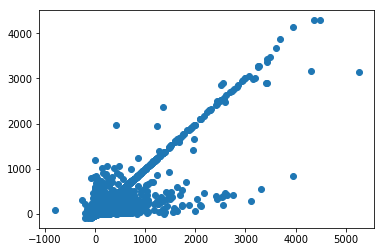

In [120]:
plot = plt.scatter(y_test,y_predicted)

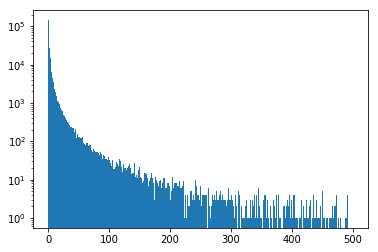

In [95]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 500], log=True);

Let's also check feature importance:

In [132]:
X_non_text = pd.get_dummies(df[cat_cols])

feature_names = list(X_non_text.columns)+bool_cols+numeric_cols

i = 0
feature_importance = dict(zip(feature_names, rf.feature_importances_))
for name, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:<30}: {importance:>6.2%}")
  
print(f"\nTotal importance: {sum(feature_importance.values()):.2%}")

comment_tree_root_score       : 58.78%
time_since_comment_tree_root  : 12.19%
parent_score                  :  5.50%
time_since_parent             :  5.08%
depth                         :  4.45%
gilded                        :  4.01%
is_root                       :  1.74%
time_since_link               :  1.32%
num_comments                  :  0.82%
title_cos_angle               :  0.76%
parent_cos_angle              :  0.71%
word_counts                   :  0.66%
controversiality              :  0.54%
upvote_ratio                  :  0.53%
senti_comp                    :  0.48%
senti_neu                     :  0.43%
link_ups                      :  0.43%
link_score                    :  0.39%
senti_neg                     :  0.33%
senti_pos                     :  0.32%
is_edited                     :  0.10%
subreddit_gaming              :  0.09%
subreddit_worldnews           :  0.09%
subjectivity                  :  0.07%
subreddit_movies              :  0.06%
is_selftext              